In [ ]:
%matplotlib widget

from typing import List, Tuple
import numpy as np
from scipy.ndimage import zoom
from scipy.signal import convolve2d
from skimage.filters import gaussian
from skimage.transform import rescale
from skimage import data, io, color
from skimage.util import random_noise, img_as_float32
from skimage.exposure import rescale_intensity
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
def show_images(images: List[Tuple], max_cols=3) -> None:
    n: int = len(images)
    f = plt.figure()
    f.set_size_inches(18.5, 10.5)
    rows = n / max_cols
    cols = max_cols
    
    for r in range(rows):
        for c in range(cols):
            i = r * max_cols + c
            f.add_subplot(r, c, i)
            plt.imshow(images[i][0], cmap="hot")
            plt.title(images[i][1])
            plt.colorbar(orientation="horizontal")

    plt.show()

def plot_error_over_time(timesteps, error, rrmse):
    plt.plot(range(timesteps), np.log2(error), label="Error (y_true, y_predict")
    plt.plot(range(timesteps), np.log2(rrmse), label="RRMSE (x_true, x_predict_k)")
    plt.xticks(range(timesteps))
    plt.xlabel("Timestep (t)")
    plt.ylabel("Error")
    plt.show()

#### Laplace deblur/sharpen kernel

In [ ]:
laplace_scale = 1.0
# laplace_deblur = np.array([[0, -1,  0], [-1,  5, -1], [0, -1,  0]], dtype=np.float32)
laplace_deblur = np.array([[0, -laplace_scale,  0], [-laplace_scale,  1.0 + 4*laplace_scale, -laplace_scale], [0, -laplace_scale,  0]])
# laplace_deblur = np.array([[0.0, 0.0,  0.0], [0.0,  1.0, 0.0], [0.0, 0.0,  0.0]])
delta = np.array([[0.0, 0.0,  0.0], [0.0,  1.0, 0.0], [0.0, 0.0,  0.0]])

# print(np.sum((delta - gaussian(laplace_deblur))**2))
# io.imshow(delta-gaussian(laplace_deblur))
# io.show()

#### Params of algorithm execution

In [ ]:
x_true = color.rgb2gray(data.astronaut())
# io.imshow(x_true, cmap=plt.cm.gray)
# io.show()

# number of y low resolution images
num_y_samples = 10
# controls the size of low resolution image dimensions
# note: use a value which results in integer arithmetic
downsample_factor = 0.5
x_img_dim = np.int32(x_true.shape[0])
y_img_dim = np.int32(x_img_dim * downsample_factor)
upsample_factor = np.float32(x_img_dim / y_img_dim)
# max number of IBP loops to perform
max_iter = np.int32(5)

#### Storage for per-iteration metrics (debugging)

In [ ]:
x_estimates = np.ndarray((max_iter, x_img_dim, x_img_dim), dtype=np.float32)
x_error = np.zeros(max_iter, dtype=np.float32)
x_rrmse = np.zeros(max_iter, dtype=np.float32)

#### Generate initial low-resolution images (assumed to be from imaging device - camera, telescope, etc.)

In [42]:
y_true = np.ndarray((num_y_samples, y_img_dim, y_img_dim), dtype=np.float32)

x_true_downsampled = rescale(x_true, downsample_factor, anti_aliasing=True, order=3) # bicubic

for k in range(num_y_samples):
    y_true[k] = random_noise(x_true_downsampled)

#### Predict initial estimate of high-resolution image (x<sub>0</sub>)

In [43]:
x_predict = rescale(np.average(y_true, axis=0), upsample_factor, order=3)
# Note to self: what do we do about values in image being negative during processing??
# x_predict = rescale_intensity(x_predict, out_range=(0.0, 1.0))
# io.imshow(x_predict, cmap=plt.cm.gray)
# io.show()

#### Perform IBP over t iterations

In [44]:
current_iter = np.int32(0)

while current_iter < max_iter:
    # print("Processing iteration %d..." % current_iter)

    # Predict low resolution images from high resolution image
    # note: probably a terrible way to do it atm...
    y_predict = np.ndarray((num_y_samples, y_img_dim, y_img_dim), dtype=np.float32)
    for k in range(num_y_samples):
        y_predict[k] = zoom(gaussian(x_predict), downsample_factor)
    
    # Calculate the error between low_res and low_res_predicted
    l2norm_sum_squares = 0.0
    for k in range(num_y_samples):
        l2norm_sum_squares = l2norm_sum_squares + np.linalg.norm(y_true[k] - y_predict[k])**2
    error = np.sqrt(1.0/num_y_samples * l2norm_sum_squares)
    # print("Iter %d error: %f..." % (current_iter, error))
    x_error[current_iter] = error

    # Make high resolution version of low res predicted
    y_true_pred_diff = zoom(y_true - y_predict, (1, int(upsample_factor), int(upsample_factor)))

    # Convolve each image with sharpen filter
    for k in range(num_y_samples):
        # convolve with laplacian deblur, trim edges (padded during convolution)
        y_true_pred_diff[k] = convolve2d(y_true_pred_diff[k], laplace_deblur, mode="same") #[1:x_img_dim+1, 1:x_img_dim+1]
    
    # Predict high resolution image
    x_new_predict = np.zeros_like(x_predict)
    sum_diff = np.sum(y_true_pred_diff, axis=0)
    # weight = max(min(error, 1.0), 0.0) # clamp func for at most 1.0 multiplier
    # weight = max(min(1.0/error, 1.0), 0.0)
    weight = 0.5
    # print("Iter %d weight: %f" % (current_iter, weight))
    x_new_predict = x_predict + sum_diff * 1.0/num_y_samples * weight
    rrmse = mean_squared_error(x_true, x_new_predict, squared=False) * 100.0
    # print("x_true min/max: %f, %f..." % (np.min(x_true), np.max(x_true)))
    # print("x_pred min/max: %f, %f..." % (np.min(x_new_predict), np.max(x_new_predict)))
    x_rrmse[current_iter] = rrmse
    # print("Iter %d rrmse %f...\n" % (current_iter, rrmse))
    np.copyto(x_predict, x_new_predict)
    np.copyto(x_estimates[current_iter], x_new_predict)
    current_iter += 1

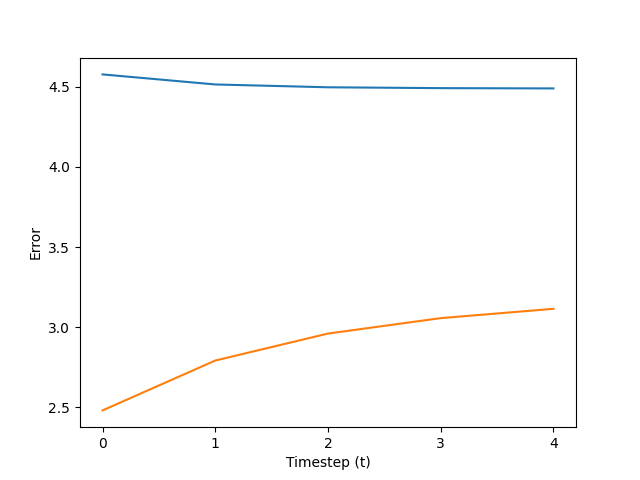

In [47]:
plot_error_over_time(max_iter, x_error, x_rrmse)

In [48]:
print("Finished processing...")

Finished processing...
